In [20]:
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt

In [10]:
def drop_missing_columns(ds):
    nan_vars = [var for var in ds.data_vars if ds[var].isnull().all()]
    ds = ds.drop_vars(nan_vars)
    
    return ds

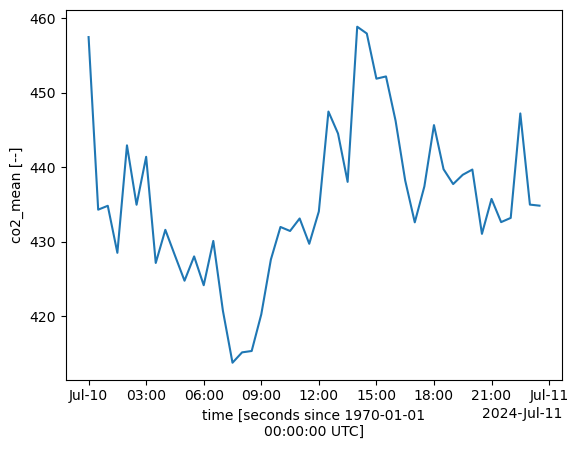

In [32]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

file_path = '/Users/bhupendra/data/delete1/summaries/2024-07-10_smart3-00694_EP-Summary.txt'

# Read the file into a pandas DataFrame
with open(file_path, 'r') as f:
    lines = f.readlines()

# Extract the units line
units_line = lines[1].strip().split('\t')

# Create a list of column names from the first line
columns = lines[0].strip().split('\t')

# Create a dictionary for units
units_dict = {columns[i]: units_line[i] for i in range(len(columns))}

# Read the data into a DataFrame, skipping the first two lines
df = pd.read_csv(file_path, sep='\t', skiprows=2, names=columns)

# Combine the 'date' and 'time' columns into a single datetime column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Set the new datetime column as the index and remove the original 'date' and 'time' columns
df.set_index('datetime', inplace=True)
df.drop(columns=['date', 'time'], inplace=True)

# Convert the DataFrame to an xarray Dataset
ds = df.to_xarray()

# Attach units as attributes to the Dataset
for var in ds.data_vars:
    if var in units_dict:
        ds[var].attrs['units'] = units_dict[var]

# Set the units attribute for the time coordinate
ds = ds.rename({'datetime': 'time'})
ds['time'].attrs['units'] = 'seconds since 1970-01-01 00:00:00 UTC'
ds['time'].attrs['calendar'] = 'standard'

# Ensure the time coordinate is CF-compliant
ds['time'].encoding['units'] = 'seconds since 1970-01-01 00:00:00'
ds['time'].encoding['calendar'] = 'standard'


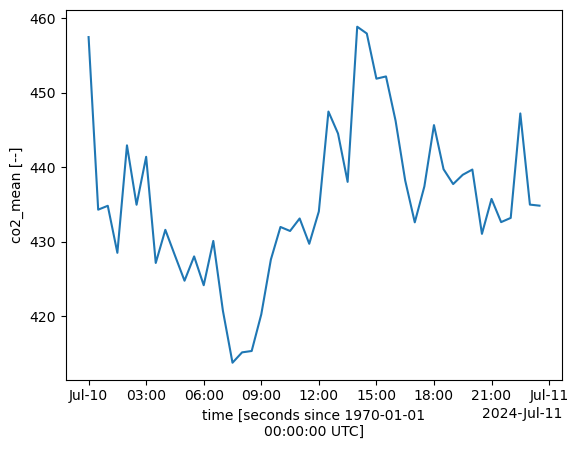

In [42]:

# Plotting the variable 'co2_mean' if it exists
if 'co2_mean' in ds.data_vars:
    ds['co2_mean'].plot()
    plt.show()



In [49]:
import os
import glob
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

metadata = {
    'filename': {'long_name': 'file name', 'units': 'NA', 'description': 'Name of the file'},
    'date': {'long_name': 'date', 'units': 'NA', 'description': 'Date of the record'},
    'time': {'long_name': 'time', 'units': 'NA', 'description': 'Time of the record'},
    'DOY': {'long_name': 'day of year', 'units': 'ddd.ddd', 'description': 'Day of the year'},
    'daytime': {'long_name': 'daytime flag', 'units': '1=daytime', 'description': 'Daytime flag (1=daytime)'},
    'file_records': {'long_name': 'file records', 'units': '#', 'description': 'Number of records in the file'},
    'used_records': {'long_name': 'used records', 'units': '#', 'description': 'Number of records used'},
    'Tau': {'long_name': 'momentum flux', 'units': 'kg m-1s-2', 'description': 'Momentum flux'},
    'qc_Tau': {'long_name': 'quality control momentum flux', 'units': '#', 'description': 'Quality control for momentum flux'},
    'rand_err_Tau': {'long_name': 'random error momentum flux', 'units': 'kg m-1s-2', 'description': 'Random error in momentum flux'},
    'H': {'long_name': 'sensible heat flux', 'units': 'W m-2', 'description': 'Sensible heat flux'},
    'qc_H': {'long_name': 'quality control sensible heat flux', 'units': '#', 'description': 'Quality control for sensible heat flux'},
    'rand_err_H': {'long_name': 'random error sensible heat flux', 'units': 'W m-2', 'description': 'Random error in sensible heat flux'},
    'LE': {'long_name': 'latent heat flux', 'units': 'W m-2', 'description': 'Latent heat flux'},
    'qc_LE': {'long_name': 'quality control latent heat flux', 'units': '#', 'description': 'Quality control for latent heat flux'},
    'rand_err_LE': {'long_name': 'random error latent heat flux', 'units': 'W m-2', 'description': 'Random error in latent heat flux'},
    'co2_flux': {'long_name': 'CO2 flux', 'units': 'µmol s-1m-2', 'description': 'CO2 flux'},
    'qc_co2_flux': {'long_name': 'quality control CO2 flux', 'units': '#', 'description': 'Quality control for CO2 flux'},
    'rand_err_co2_flux': {'long_name': 'random error CO2 flux', 'units': 'µmol s-1m-2', 'description': 'Random error in CO2 flux'},
    'h2o_flux': {'long_name': 'H2O flux', 'units': 'mmol s-1m-2', 'description': 'H2O flux'},
    'qc_h2o_flux': {'long_name': 'quality control H2O flux', 'units': '#', 'description': 'Quality control for H2O flux'},
    'rand_err_h2o_flux': {'long_name': 'random error H2O flux', 'units': 'mmol s-1m-2', 'description': 'Random error in H2O flux'},
    'ch4_flux': {'long_name': 'CH4 flux', 'units': 'µmol s-1m-2', 'description': 'CH4 flux'},
    'qc_ch4_flux': {'long_name': 'quality control CH4 flux', 'units': '#', 'description': 'Quality control for CH4 flux'},
    'rand_err_ch4_flux': {'long_name': 'random error CH4 flux', 'units': 'µmol s-1m-2', 'description': 'Random error in CH4 flux'}
}

def read_file(file_path):
    """Read and process a single file into a pandas DataFrame and units dictionary."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    units_line = lines[1].strip().split('\t')
    columns = lines[0].strip().split('\t')
    units_dict = {columns[i]: units_line[i] for i in range(len(columns))}
    
    df = pd.read_csv(file_path, sep='\t', skiprows=2, names=columns)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.drop(columns=['date', 'time'], inplace=True)
    
    return df, units_dict

def read_all_files(filenames):
    """Combine multiple DataFrames for a month into a single DataFrame."""
    combined_df = pd.DataFrame()
    common_units_dict = {}

    for file in filenames:
        df, units = read_file(file)
        combined_df = pd.concat([combined_df, df])
        
        # Ensure units dictionary is consistent and capture only the first one
        if not common_units_dict:
            common_units_dict = units

    combined_df.set_index('datetime', inplace=True)
    return combined_df, common_units_dict

def df_to_xarray(df, metadata):
    """Convert pandas DataFrame to xarray Dataset and attach metadata."""
    ds = xr.Dataset.from_dataframe(df)
    
    for var in ds.data_vars:
        if var in metadata:
            ds[var].attrs['long_name'] = metadata[var]['long_name']
            ds[var].attrs['units'] = metadata[var]['units']
            ds[var].attrs['description'] = metadata[var]['description']
    
    ds = ds.rename({'datetime': 'time'})
    return ds





# Directory containing the files
root_dir = '/Users/bhupendra/data/delete1'
sum_folder = os.path.join(root_dir, 'summaries')
output_folder = os.path.join(root_dir, 'summaries_nc')
year_month = '2024-07'  # Example: process data for July 2024


"""Process data files for a specified month and save to a NetCDF file."""
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

pattern = os.path.join(sum_folder, f'*{year_month}*.txt')
filenames = glob.glob(pattern)

combined_df, _ = read_all_files(filenames)
ds = df_to_xarray(combined_df, metadata)
    



In [ ]:

# Write the xarray Dataset to a NetCDF file
output_path = 'output.nc'
ds.to_netcdf(output_path)

print(f"NetCDF file saved to {output_path}")



In [50]:
ds


<xarray.Dataset> Size: 1MB
Dimensions:                         (time: 767)
Coordinates:
  * time                            (time) datetime64[ns] 6kB 2024-07-08 ... ...
Data variables: (12/181)
    DATAH                           (time) object 6kB 'DATA' 'DATA' ... 'DATA'
    filename                        (time) object 6kB '2024-07-07T233000_smar...
    DOY                             (time) float64 6kB 190.0 190.0 ... 187.0
    daytime                         (time) int64 6kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    file_records                    (time) int64 6kB 18000 18000 ... 18000 18000
    used_records                    (time) int64 6kB 18000 18000 ... 18000 18000
    ...                              ...
    vin_sf_mean                     (time) float64 6kB 24.0 24.0 ... 24.0 23.99
    co2_mean                        (time) float64 6kB 458.6 452.9 ... 426.8
    h2o_mean                        (time) float64 6kB 23.49 23.0 ... 21.86
    dew_point_mean                  (time) float64 6kB 19.92 19.57 ... 18.7
    co2_signal_strength_7500_mean   (time) float64 6kB 68.01 71.44 ... 97.86
    CHK                             (time) int64 6kB 155 24 10 69 ... 120 207 86

In [41]:
import os
import glob
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

def read_file(file_path):
    """Read and process a single file into a pandas DataFrame and units dictionary."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    units_line = lines[1].strip().split('\t')
    columns = lines[0].strip().split('\t')
    units_dict = {columns[i]: units_line[i] for i in range(len(columns))}
    
    df = pd.read_csv(file_path, sep='\t', skiprows=2, names=columns)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.drop(columns=['date', 'time'], inplace=True)
    
    return df, units_dict

def read_all_files(filenames):
    """Combine multiple DataFrames for a month into a single DataFrame."""
    combined_df = pd.DataFrame()
    common_units_dict = {}

    for file in filenames:
        df, units = read_file(file)
        combined_df = pd.concat([combined_df, df])
        
        # Ensure units dictionary is consistent and capture only the first one
        if not common_units_dict:
            common_units_dict = units

    combined_df.set_index('datetime', inplace=True)
    return combined_df, common_units_dict

def df_to_xarray(df, units_dict):
    """Convert pandas DataFrame to xarray Dataset and attach units."""
    ds = df.to_xarray()
    
    for var in ds.data_vars:
        if var in units_dict:
            ds[var].attrs['units'] = units_dict[var]
    
    ds = ds.rename({'datetime': 'time'})
    
    # Remove existing 'units' attribute to avoid conflicts
    if 'units' in ds['time'].attrs:
        del ds['time'].attrs['units']
        
    ds['time'].attrs['units'] = 'seconds since 1970-01-01 00:00:00 UTC'
    ds['time'].attrs['calendar'] = 'standard'
    ds['time'].encoding['units'] = 'seconds since 1970-01-01 00:00:00'
    ds['time'].encoding['calendar'] = 'standard'
    
    return ds

def ds_to_netcdf(ds, output_path):
    """Save xarray Dataset to a NetCDF file."""
    ds.to_netcdf(output_path)
    print(f"NetCDF file saved to {output_path}")

def process(input_folder, output_folder, year_month):
    """Process data files for a specified month and save to a NetCDF file."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    pattern = os.path.join(input_folder, f'*{year_month}*.txt')
    filenames = glob.glob(pattern)
    
    combined_df, units_dict = read_all_files(filenames)
    ds = df_to_xarray(combined_df, units_dict)
    
    output_path = os.path.join(output_folder, f'{year_month}_summary.nc')
    ds_to_netcdf(ds, output_path)

# Directory containing the files
root_dir = '/Users/bhupendra/data/delete1'
sum_folder = os.path.join(root_dir, 'summaries')
output_folder = os.path.join(root_dir, 'summaries_nc')
year_month = '2024-07'  # Example: process data for July 2024

process(sum_folder, output_folder, year_month)


ValueError: failed to prevent overwriting existing key units in attrs on variable 'time'. This is probably an encoding field used by xarray to describe how a variable is serialized. To proceed, remove this key from the variable's attributes manually.

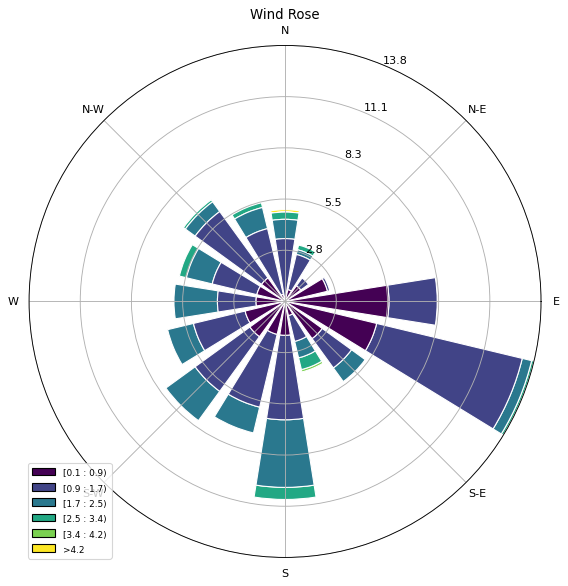

In [5]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes

def plot_wind_rose(ds, wind_speed_var='wind_speed', wind_dir_var='wind_dir'):
    # Check if the required variables are in the dataset
    if wind_speed_var not in ds.variables or wind_dir_var not in ds.variables:
        print(f"Variables '{wind_speed_var}' and/or '{wind_dir_var}' not found in the dataset.")
        return
    
    # Extract wind speed and direction
    wind_speed = ds[wind_speed_var].values
    wind_dir = ds[wind_dir_var].values
    
    # Create wind rose plot
    ax = WindroseAxes.from_ax()
    ax.bar(wind_dir, wind_speed, normed=True, opening=0.8, edgecolor='white')
    
    # Set plot title and labels
    ax.set_title('Wind Rose')
    ax.set_legend()
    plt.show()


plot_wind_rose(ds)


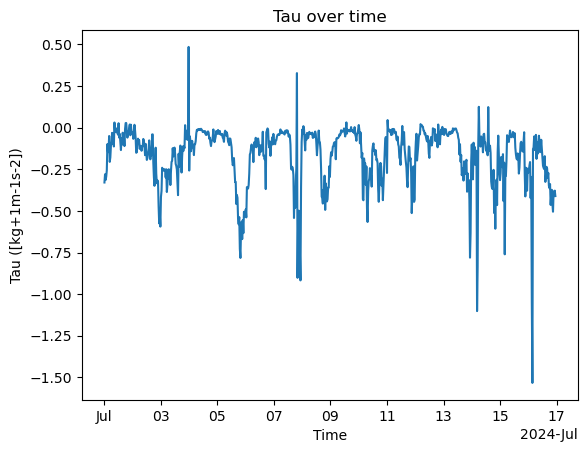

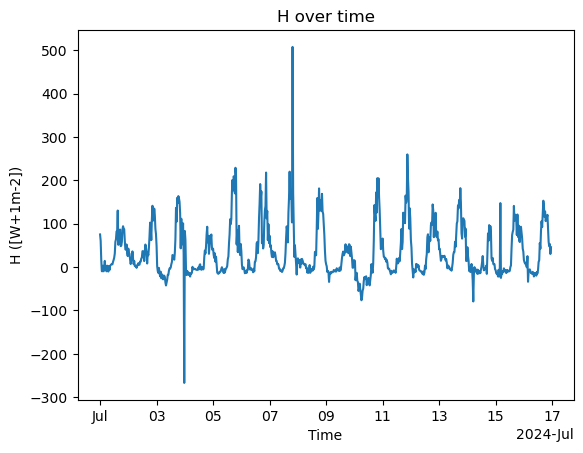

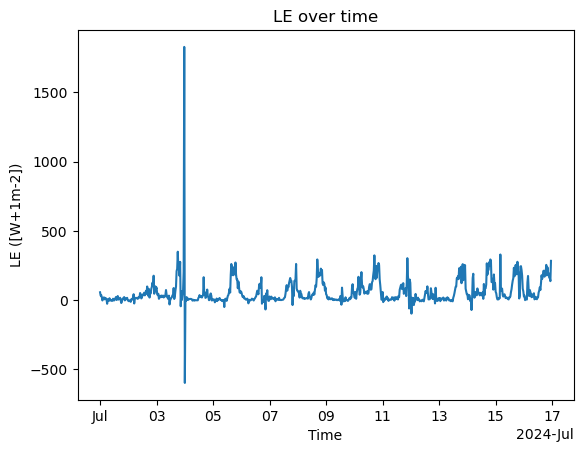

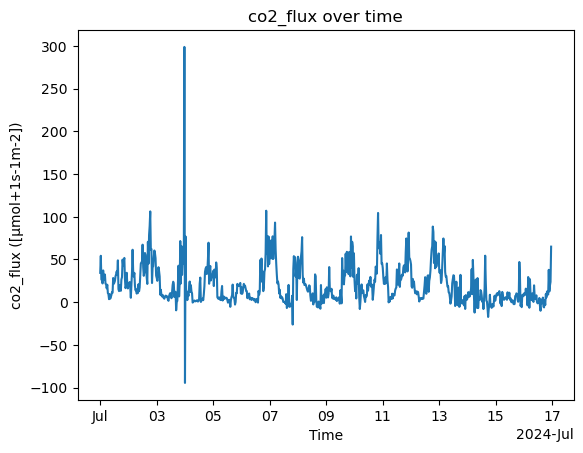

In [32]:
import matplotlib.pyplot as plt

def plot_vars(ds, vars):
    # Check if these variables are in the dataset
    for var in vars:
        if var not in ds.variables:
            print(f"Variable '{var}' not found in the dataset.")
            continue
        
        # Plot
        plt.figure()
        ds[var].plot()
        plt.title(f'{var} over time')
        plt.xlabel('Time')
        plt.ylabel(f'{var} ({ds[var].attrs.get("units", "")})')
        plt.show()


vars = ['Tau', 'H', 'LE', 'co2_flux']
plot_vars(ds, vars)



In [7]:
import sage_data_client

df = sage_data_client.query(
    start="-1d", 
    filter={
        "plugin": "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.24.4.19",
        "vsn": "W08D|W099|W0A4"
    }
)

df

,timestamp,name,value,meta.host,meta.missing,meta.node,meta.plugin,meta.sensor,meta.task,meta.units,meta.vsn,meta.zone
0,2024-07-23 20:07:07.108317061+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
1,2024-07-23 20:07:07.188408016+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
2,2024-07-23 20:07:07.268351320+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
3,2024-07-23 20:07:07.348313120+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
4,2024-07-23 20:07:07.428665361+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
...,...,...,...,...,...,...,...,...,...,...,...,...
24601007,2024-07-24 09:25:43.737372384+00:00,wxt.wind.speed,0.5,000048b02dd3c76e.ws-nxcore,-9999.9,000048b02dd3c76e,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,meters per second,W0A4,core
24601008,2024-07-24 09:25:43.817770385+00:00,wxt.wind.speed,0.5,000048b02dd3c76e.ws-nxcore,-9999.9,000048b02dd3c76e,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,meters per second,W0A4,core
24601009,2024-07-24 09:25:43.897266297+00:00,wxt.wind.speed,0.5,000048b02dd3c76e.ws-nxcore,-9999.9,000048b02dd3c76e,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,meters per second,W0A4,core
24601010,2024-07-24 09:25:43.977037988+00:00,wxt.wind.speed,0.5,000048b02dd3c76e.ws-nxcore,-9999.9,000048b02dd3c76e,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,meters per second,W0A4,core


In [10]:
df = df.set_index('timestamp')

In [11]:
df

,name,value,meta.host,meta.missing,meta.node,meta.plugin,meta.sensor,meta.task,meta.units,meta.vsn,meta.zone
timestamp,,,,,,,,,,,
2024-07-23 20:07:07.108317061+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
2024-07-23 20:07:07.188408016+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
2024-07-23 20:07:07.268351320+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
2024-07-23 20:07:07.348313120+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
2024-07-23 20:07:07.428665361+00:00,wxt.env.humidity,48.2,000048b02d3ae277.ws-nxcore,-9999.9,000048b02d3ae277,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,percent,W08D,core
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24 09:25:43.737372384+00:00,wxt.wind.speed,0.5,000048b02dd3c76e.ws-nxcore,-9999.9,000048b02dd3c76e,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,meters per second,W0A4,core
2024-07-24 09:25:43.817770385+00:00,wxt.wind.speed,0.5,000048b02dd3c76e.ws-nxcore,-9999.9,000048b02dd3c76e,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,meters per second,W0A4,core
2024-07-24 09:25:43.897266297+00:00,wxt.wind.speed,0.5,000048b02dd3c76e.ws-nxcore,-9999.9,000048b02dd3c76e,registry.sagecontinuum.org/jrobrien/waggle-wxt...,vaisala-wxt536,waggle-wxt536,meters per second,W0A4,core


ValueError: Invalid color name

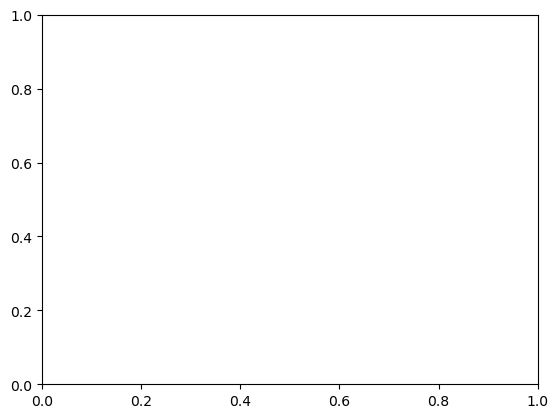

In [21]:
df.plot(y='value', color='name')

In [16]:
df['name'].unique()

array(['wxt.env.humidity', 'wxt.env.pressure', 'wxt.env.temp',
       'wxt.heater.temp', 'wxt.heater.volt', 'wxt.rain.accumulation',
       'wxt.wind.direction', 'wxt.wind.speed'], dtype=object)